In [3]:
from transformers import pipeline
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns


zeroshot_classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33",
)

2024-10-06 18:05:07.902363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Running the ads through DEBERTA

In [2]:
# text = "Texas’ new law puts the lives of millions in danger. And the truth is that these restrictions will disproportionately impact people of color, poor people, queer people, and young people. We need bold action to immediately guarantee access to abortion care as a right."
hypothesis_template = "This ad is about {}"
classes_verbalized = [
    "Economy",
    "Civil Rights",
    "Healthcare",
    "Agriculture",
    "Labor and Employment",
    "Education and Culture",
    "Climate",
    "Immigration",
    "Transport",
    "Law and Crime",
    "Social Welfare",
    "Housing",
    "Defense",
    "Foreign Affair",
    "Government",
    "Unclear"   #placeholder category
]  # 

# output = zeroshot_classifier(
#    text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False
# )
# print(output)

In [2]:
data = pd.read_csv("filtered_data.csv")
unique_txt = data['ad_creative_body'].unique()
# print(unique_txt.size) 58.449 unique ad text bites to proces

In [4]:
text_to_vector = {} # dict to store the model outcome

for text in unique_txt:
    hypo = f"This ad is about {{}}"
    output = zeroshot_classifier(
        text,
        classes_verbalized,
        hypothesis_template=hypothesis_template,
        multi_label=False,
    )
    text_to_vector[text] = {
        "labels": output["labels"],  # keep all labels and their corresponding scores in a list format
        "scores": output["scores"],  
    }

# Making two new columns 
data["labels"] = data["ad_creative_body"].map(
    lambda text: text_to_vector[text]["labels"]
)
data["scores"] = data["ad_creative_body"].map(
    lambda text: text_to_vector[text]["scores"]
)

In [5]:
data.to_csv("deberta_first_run.csv", index=False)

## Some basic stats on labelled data

In [7]:
label_data = pd.read_csv(
    "/Users/sofiepalmuskronborg/Desktop/ekstre_thesis/deberta_first_run.csv"
)

In [14]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459728 entries, 0 to 598016
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                459728 non-null  int64  
 1   ad_creation_time          459728 non-null  object 
 2   ad_creative_body          459728 non-null  object 
 3   spend                     459728 non-null  float64
 4   impressions               459728 non-null  float64
 5   delivery_by_region        459728 non-null  object 
 6   demographic_distribution  459728 non-null  object 
 7   page_id                   459728 non-null  int64  
 8   page_name                 459728 non-null  object 
 9   bylines                   458487 non-null  object 
 10  id                        459728 non-null  int64  
 11  spend_lo                  459728 non-null  int64  
 12  spend_hi                  459728 non-null  int64  
 13  impressions_lo            459728 non-null  i

In [8]:
# sort away duplicate ad texts coming from the same politician
label_data_unique = label_data.drop_duplicates(subset=['ad_creative_body', 'page_id'])

In [17]:
label_data_unique.info() # from 459.728 ads to 58.574 ads !!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58574 entries, 0 to 598016
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                58574 non-null  int64  
 1   ad_creation_time          58574 non-null  object 
 2   ad_creative_body          58574 non-null  object 
 3   spend                     58574 non-null  float64
 4   impressions               58574 non-null  float64
 5   delivery_by_region        58574 non-null  object 
 6   demographic_distribution  58574 non-null  object 
 7   page_id                   58574 non-null  int64  
 8   page_name                 58574 non-null  object 
 9   bylines                   58339 non-null  object 
 10  id                        58574 non-null  int64  
 11  spend_lo                  58574 non-null  int64  
 12  spend_hi                  58574 non-null  int64  
 13  impressions_lo            58574 non-null  int64  
 14  impre

In [40]:
label_data_unique.dtypes

Unnamed: 0                    int64
ad_creation_time             object
ad_creative_body             object
spend                       float64
impressions                 float64
delivery_by_region           object
demographic_distribution     object
page_id                       int64
page_name                    object
bylines                      object
id                            int64
spend_lo                      int64
spend_hi                      int64
impressions_lo                int64
impressions_hi                int64
party                        object
state                        object
labels                       object
scores                       object
top_label                    object
top_score                    object
dtype: object

In [11]:
# converts 'labels' and 'scores' column from object to a list to be able to retrieve the first instance -> top score/top_label

label_data_unique["labels"] = label_data_unique["labels"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
label_data_unique["scores"] = label_data_unique["scores"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Retrieving first instance in each column
label_data_unique["top_label"] = label_data_unique["labels"].str[0]
label_data_unique["top_score"] = label_data_unique["scores"].str[0]

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_5073/1971677923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_unique["labels"] = label_data_unique["labels"].apply(
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_5073/1971677923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_unique["scores"] = label_data_unique["scores"].apply(
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_5073/1971677923.py:11: SettingWithCopyWarning: 
A value is trying to 

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_5073/2268411410.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_counts.index, y=party_counts.values, palette="Blues")


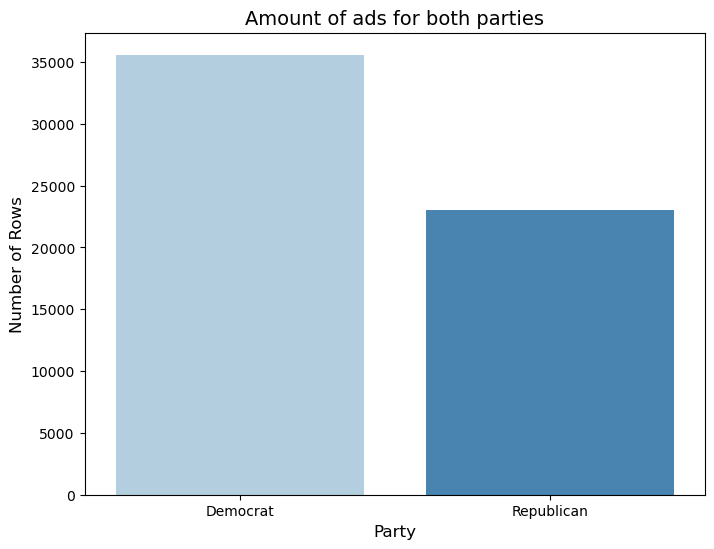

In [14]:
# Filter data rows based on party to work with stats on the individual parties
label_data_D = label_data_unique[label_data_unique["party"] == "Democrat"]
label_data_R = label_data_unique[label_data_unique["party"] == "Republican"]

# get an value of the count of rows for both parties/politicians
party_counts = label_data_unique["party"].value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=party_counts.index, y=party_counts.values, palette="Blues")
plt.title("Amount of ads for both parties", fontsize=14)
plt.xlabel("Party", fontsize=12)
plt.ylabel("Number of Rows", fontsize=12)
plt.show()

In [39]:
# saving another CSV file with the two new columns
label_data_unique.to_csv("deberta_top_labels.csv")

## Vizualising + stats

Text(0, 0.5, 'Frequency')

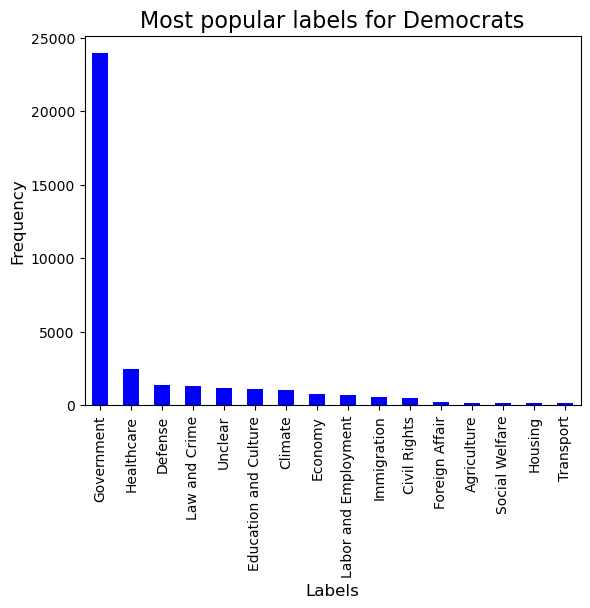

In [35]:
top_labels_D = (label_data_D["top_label"].value_counts()).iloc[:16] # all labels

# plotting
top_labels_D.plot(kind="bar", color="blue")
plt.title("Most popular labels for Democrats", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

In [36]:
# calcu the amount + % for each top
top_D_percentages = (
    label_data_D["top_label"].value_counts(normalize=True).iloc[:16]
) * 100

# Print the counts and percentages in a readable format
print("Stats for 'Democratic ads' and top labels:\n")
for label, count, percentage in zip(
    top_labels_D.index, top_labels_D.values, top_D_percentages.values
):
    print(f"{label}: {count} ads ({percentage:.2f}%)")

Stats for 'Democratic ads' and top labels:

Government: 23947 ads (67.30%)
Healthcare: 2461 ads (6.92%)
Defense: 1402 ads (3.94%)
Law and Crime: 1275 ads (3.58%)
Unclear: 1152 ads (3.24%)
Education and Culture: 1072 ads (3.01%)
Climate: 1010 ads (2.84%)
Economy: 772 ads (2.17%)
Labor and Employment: 687 ads (1.93%)
Immigration: 571 ads (1.60%)
Civil Rights: 480 ads (1.35%)
Foreign Affair: 228 ads (0.64%)
Agriculture: 168 ads (0.47%)
Social Welfare: 121 ads (0.34%)
Housing: 121 ads (0.34%)
Transport: 118 ads (0.33%)


Text(0, 0.5, 'Frequency')

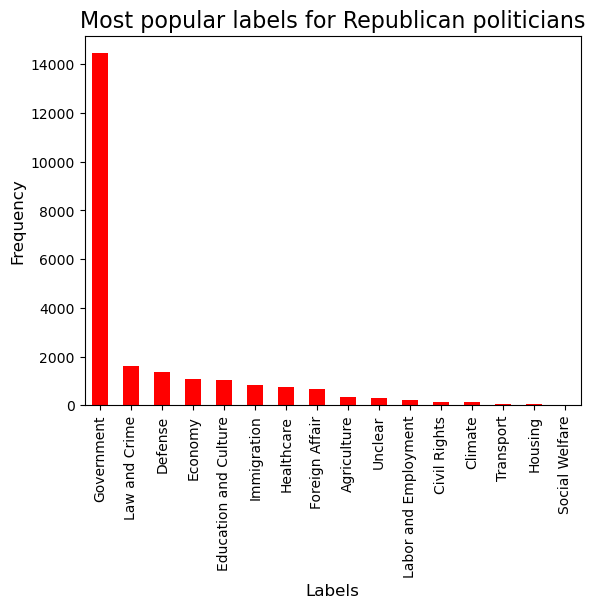

In [37]:
top_labels_R = (label_data_R["top_label"].value_counts()).iloc[:16]

# plotting
top_labels_R.plot(kind="bar", color="red")

plt.title("Most popular labels for Republican politicians", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

In [38]:
top_R_percentages = (
    label_data_R["top_label"].value_counts(normalize=True).iloc[:16]
) * 100

# Print the counts and percentages in a readable format
print("Stats for 'Republican ads' and their top labels:\n")
for label, count, percentage in zip(
    top_labels_R.index, top_labels_R.values, top_R_percentages.values
):
    print(f"{label}: {count} ads ({percentage:.2f}%)")

Stats for 'Republican ads' and their top labels:

Government: 14452 ads (62.86%)
Law and Crime: 1622 ads (7.06%)
Defense: 1357 ads (5.90%)
Economy: 1096 ads (4.77%)
Education and Culture: 1035 ads (4.50%)
Immigration: 850 ads (3.70%)
Healthcare: 741 ads (3.22%)
Foreign Affair: 667 ads (2.90%)
Agriculture: 329 ads (1.43%)
Unclear: 305 ads (1.33%)
Labor and Employment: 206 ads (0.90%)
Civil Rights: 119 ads (0.52%)
Climate: 113 ads (0.49%)
Transport: 45 ads (0.20%)
Housing: 41 ads (0.18%)
Social Welfare: 11 ads (0.05%)
